\
####importing required libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from zipfile import ZipFile

####calling the zip file and extracting the data

In [ ]:
with ZipFile("/content/drive/MyDrive/Final Sem Project/UTKFace.zip") as zipObject:
  zipObject.extractall()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####setting paths

In [ ]:
BASE_DIR = '/content/UTKFace'

####This code is creating three empty lists to store image paths, age labels, and gender labels. Then, it is iterating through all the files in the directory specified by BASE_DIR, which contains the image files. For each image file, it is extracting the age and gender information from the file name using the split function

In [ ]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

####Convert into dataframe

In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/UTKFace/40_1_2_20170116163713862.jpg....,40,1
1,/content/UTKFace/24_0_1_20170117194359125.jpg....,24,0
2,/content/UTKFace/71_0_0_20170111195259809.jpg....,71,0
3,/content/UTKFace/24_1_3_20170119164716909.jpg....,24,1
4,/content/UTKFace/37_0_1_20170117191953052.jpg....,37,0


####map labels for gender

In [ ]:
gender_dict = {0:'Male', 1:'Female'}

#### Showing image

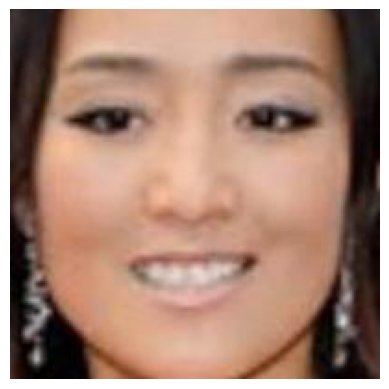

In [ ]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

#### Plot of age distribution



<Axes: xlabel='age', ylabel='Density'>

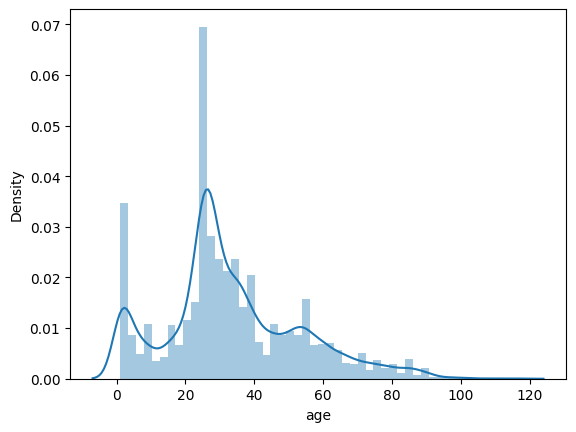

In [ ]:
sns.distplot(df['age'])

####plot of gender counting

In [ ]:
df['gender']

0        1
1        0
2        0
3        1
4        0
        ..
23703    1
23704    0
23705    0
23706    1
23707    0
Name: gender, Length: 23708, dtype: int64

<Axes: xlabel='gender', ylabel='frequency'>

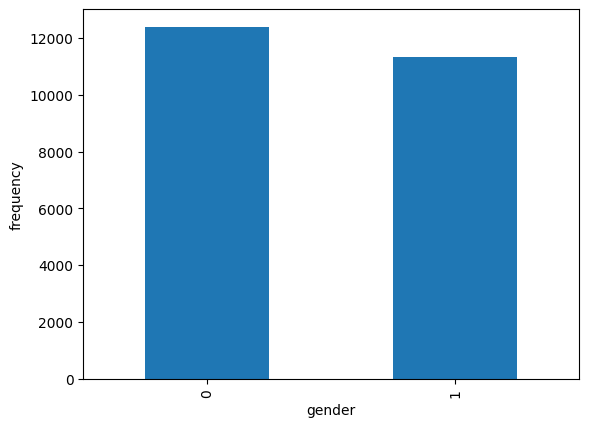

In [ ]:
fig, ax = plt.subplots()
df['gender'].value_counts().plot(ax=ax, kind='bar', xlabel='gender', ylabel='frequency')

####This code defines a function called extract_features that takes in a list of image file paths and returns a NumPy array of image features.

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((48, 48), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

####feature extraction

In [ ]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

####rescaling

In [ ]:
X = X/255.0

####creating two numpy arrays y_gender and y_age, which contain the gender and age labels, respectively, from a Pandas DataFrame df.

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

####defining the input shape

In [ ]:
input_shape = (48, 48, 1)

####creating neural network model

In [ ]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

note:
The rectified linear unit (ReLU) activation function is commonly used in deep learning models, especially in convolutional neural networks (CNNs), because it tends to produce better results than other activation functions. ReLU sets all negative values in the input to zero and leaves the positive values unchanged, producing a non-linear output that is computationally efficient to compute. It is used when we want to introduce non-linearity into the model and improve its performance. ReLU activation is often used in hidden layers of a neural network.

The sigmoid activation function is used in the output layer of neural networks for binary classification problems. The sigmoid function maps any real-valued number to a value between 0 and 1, which can be interpreted as the probability of the input belonging to a particular class. It is commonly used in logistic regression and binary classification problems. For example, in this code, the sigmoid activation function is used in the gender_out output layer to predict the probability of an input image representing a male or female. The output value of sigmoid activation function is interpreted as the probability of the input image belonging to the positive class (i.e., male or female).

#### plot the model


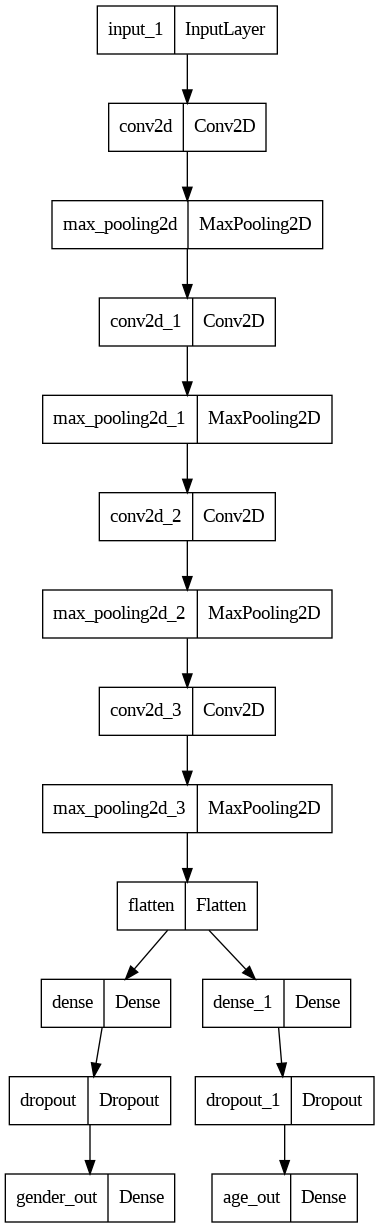

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

#### train model


In [ ]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 18s 10ms/step - loss: 15.9064 - gender_out_loss: 0.7148 - age_out_loss: 15.1916 - gender_out_accuracy: 0.5185 - age_out_accuracy: 0.0467 - val_loss: 13.8476 - val_gender_out_loss: 0.6678 - val_age_out_loss: 13.1798 - val_gender_out_accuracy: 0.5976 - val_age_out_accuracy: 0.0491
Epoch 2/30
593/593 [==============================] - 6s 11ms/step - loss: 13.2684 - gender_out_loss: 0.6042 - age_out_loss: 12.6642 - gender_out_accuracy: 0.6781 - age_out_accuracy: 0.0452 - val_loss: 11.8237 - val_gender_out_loss: 0.5455 - val_age_out_loss: 11.2782 - val_gender_out_accuracy: 0.7254 - val_age_out_accuracy: 0.0411
Epoch 3/30
593/593 [==============================] - 5s 8ms/step - loss: 11.2528 - gender_out_loss: 0.5190 - age_out_loss: 10.7337 - gender_out_accuracy: 0.7480 - age_out_accuracy: 0.0238 - val_loss: 10.0852 - val_gender_out_loss: 0.4771 - val_age_out_loss: 9.6080 - val_gender_out_accuracy: 0.7756 - val_age_out_accuracy: 0.0135
Ep

#### plot results for gender


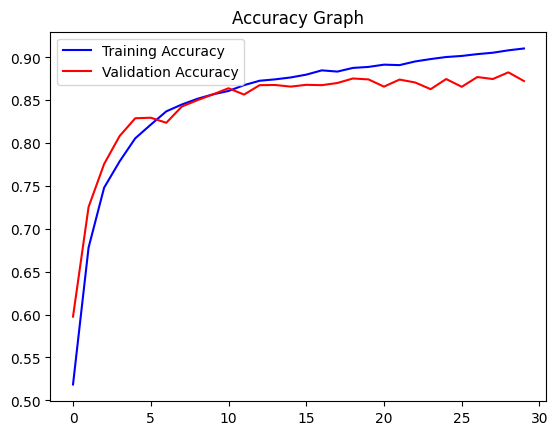

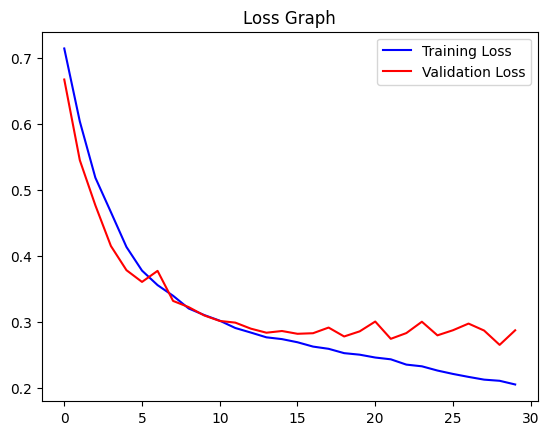

In [ ]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

#### plot results for age


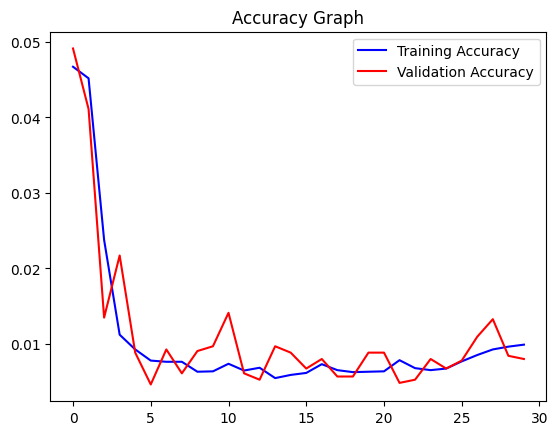

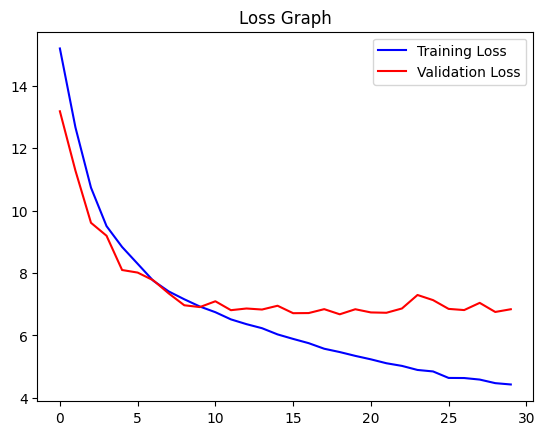

In [ ]:
acc = history.history['age_out_accuracy']
val_acc = history.history['val_age_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

####getting result

Original Gender: Female Original Age: 4
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Female Predicted Age: 19


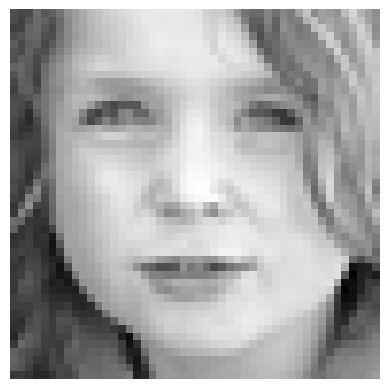

In [ ]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 48, 48, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(48, 48), cmap='gray')

#Emotion Detection

####importing libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

####importing file

In [ ]:
with ZipFile("/content/drive/MyDrive/Final Sem Project/Fer2013_Dataset.zip") as zipObject:
  zipObject.extractall()

####splitting training and testing dictionary and count the images

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + "/" + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  neutral  happy  surprise  fear   sad
train   3995      436     4965   7215      3171  4097  4830
      angry  disgust  neutral  happy  surprise  fear   sad
test    958      111     1233   1774       831  1024  1247


####plotting the training dictionary

<Axes: >

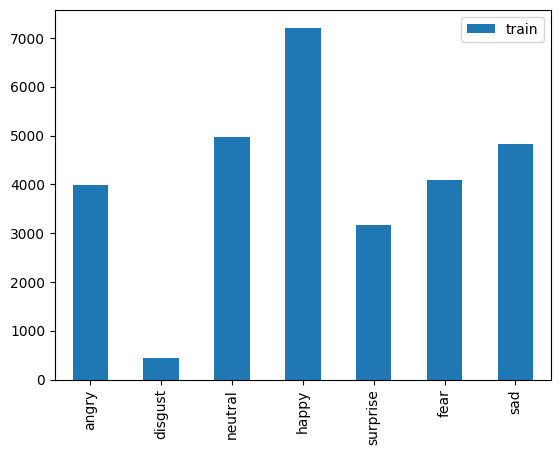

In [ ]:
train_count.transpose().plot(kind='bar')

####plotting test dictionary

<Axes: >

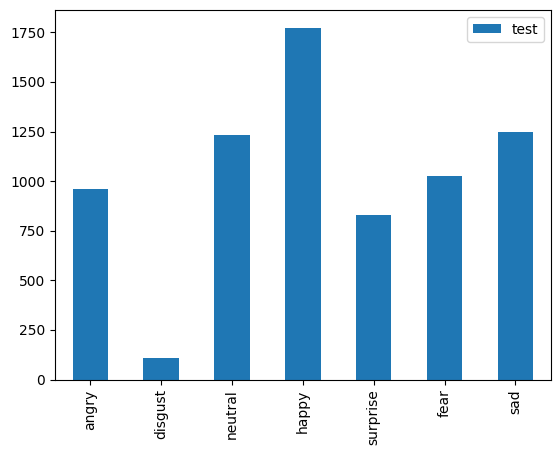

In [ ]:
test_count.transpose().plot(kind='bar')

####This code plots a sample image from each expression in the training dataset using Matplotlib.



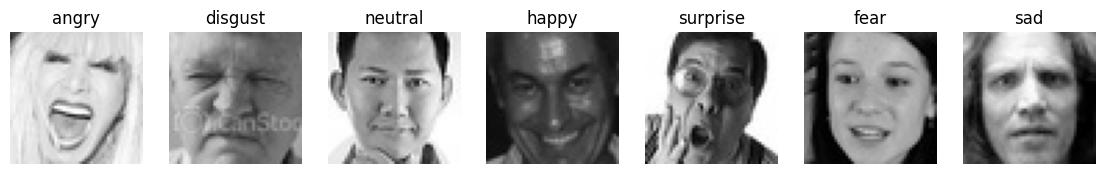

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + '/' + expression +'/'+ os.listdir(train_dir + '/' + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

####The code is providing the ImageDataGenerator class from Keras to create data generators for the training and test sets.

The train_datagen generator is performing data augmentation on the training images by rescaling the pixel values to the range [0,1], randomly zooming the images by up to 30%, and randomly flipping them horizontally. The training_set is then created using the flow_from_directory() method, which generates batches of augmented images from the specified training directory. The batch size is set to 64, and the target size of each image is (48,48) with grayscale color mode. The class mode is set to categorical, indicating that the labels are represented as one-hot vectors.

Similarly, the test_datagen generator is only rescaling the pixel values of the test images to the range [0,1]. The test_set is then created using the flow_from_directory() method with the same settings as the training_set.

These data generators allow the model to efficiently read in and preprocess large amounts of image data in batches during training and testing, which is essential for deep learning models that require a lot of data to generalize well. The data augmentation also helps to reduce overfitting by artificially increasing the amount of training data available.








In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


####indexing the emotions

In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

####This function defines a Convolutional Neural Network (CNN) model for facial expression recognition using the Keras API from TensorFlow. The model architecture is as follows:

Two sets of two convolutional layers followed by batch normalization, max pooling, and dropout layers. The first set has 32 and 64 filters, respectively, and the second set has 128 and 256 filters, respectively.
A flatten layer to convert the output of the convolutional layers to a 1D array.
A fully connected dense layer with 1024 units and a ReLU activation function followed by a dropout layer.
A final dense layer with classes units and a softmax activation function, where classes is the number of classes (7 for facial expressions).


In [ ]:
def get_fer_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

####The get_fer_model function defines a convolutional neural network model for facial expression recognition. Here, the fernet variable is used to create an instance of the model with an input size of (row, col, 1) and classes output classes.



In [ ]:
fernet = get_fer_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)       7

####showing the diagram

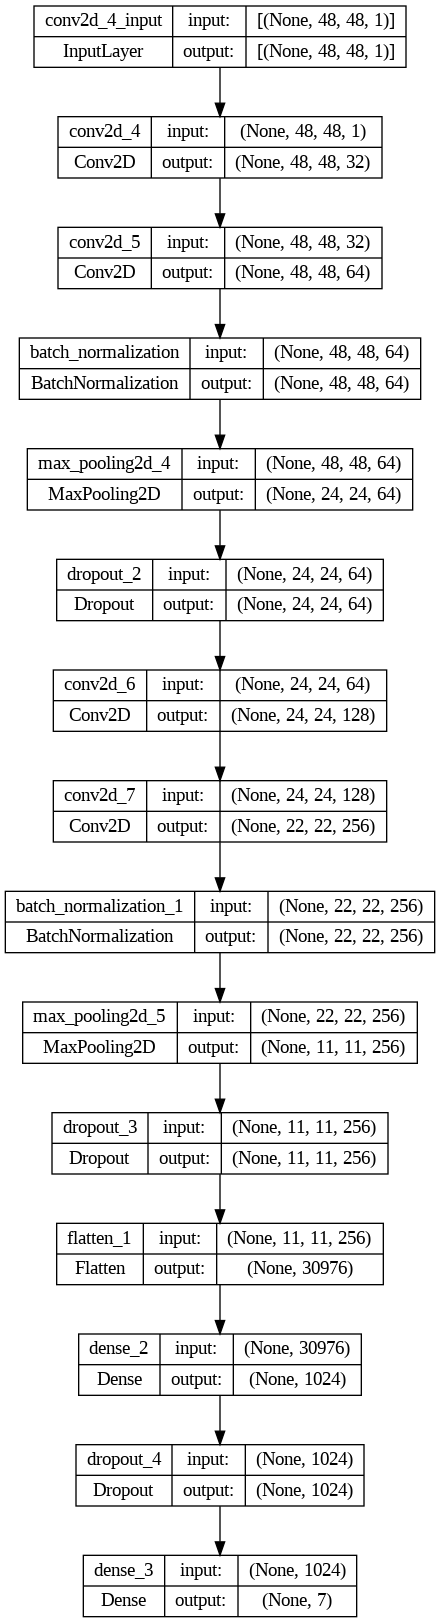

In [ ]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

####various callbacks for executing codes
Here, we define several callbacks to be used during training:

ModelCheckpoint: This callback saves the model weights after each epoch if the validation loss has improved.

EarlyStopping: This callback stops training if the validation loss does not improve for patience number of epochs.

ReduceLROnPlateau: This callback reduces the learning rate when the validation loss has plateaued, by a factor of factor.

TensorBoard: This callback writes log data to be used by TensorBoard for visualizations.

CSVLogger: This callback writes training logs to a CSV file.










In [ ]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

####deciding required steps for epoch

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.3163 - accuracy: 0.2752
Epoch 1: val_loss improved from inf to 5.86411, saving model to ferNet.h5
448/448 [==============================] - 39s 82ms/step - loss: 4.3163 - accuracy: 0.2752 - val_loss: 5.8641 - val_accuracy: 0.2222 - lr: 1.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.5475 - accuracy: 0.3311
Epoch 2: val_loss improved from 5.86411 to 3.12479, saving model to ferNet.h5
448/448 [==============================] - 35s 77ms/step - loss: 3.5475 - accuracy: 0.3311 - val_loss: 3.1248 - val_accuracy: 0.4129 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 3.0244 - accuracy: 0.3712
Epoch 3: val_loss improved from 3.12479 to 2.68123, saving model to ferNet.h5
448/448 [==============================] - 41s 92ms/step - loss: 3.0244 - accuracy: 0.3712 - val_loss: 2.6812 - val_accuracy: 0.4305 - lr: 1.0000e-04
Epoch 4/60
448/448 [============

####plotting accuracy and loss curve

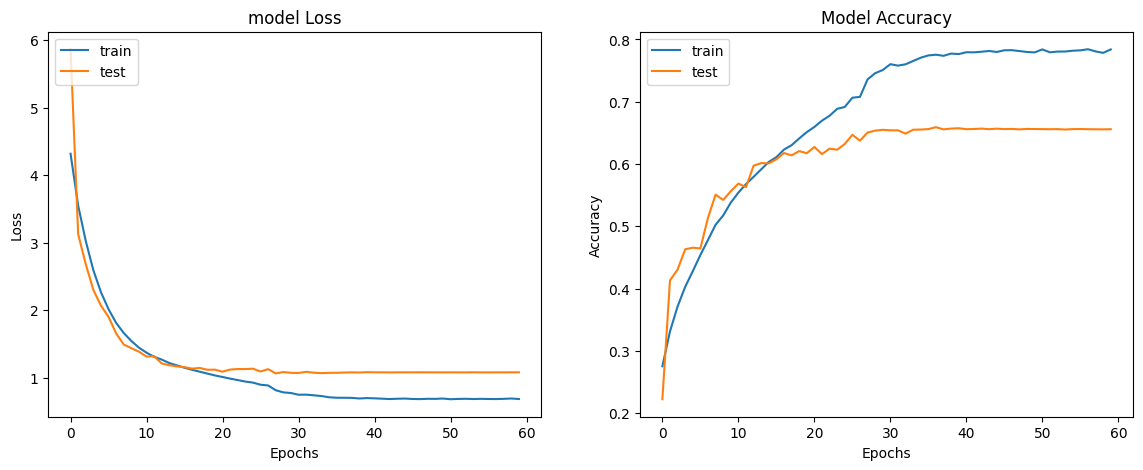

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

####getting the acuuracy value

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 25ms/step - loss: 1.0792 - accuracy: 0.6558
final train accuracy = 85.35 , validation accuracy = 65.58


#### the weights of the trained FERNet model have been saved as fernet_bestweight.h5.






In [ ]:
fernet.save_weights('fernet_bestweight.h5')

####confusion matrix for training set

449/449 [==============================] - 21s 47ms/step
Confusion Matrix
[[ 535   46  530 1018  739  664  463]
 [  60    1   47  115   81   89   43]
 [ 552   50  523 1041  776  702  453]
 [ 942   97  907 1874 1337 1251  807]
 [ 675   65  616 1323  930  811  545]
 [ 627   56  610 1255  882  862  538]
 [ 466   39  409  791  567  566  333]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.13      0.14      3995
     disgust       0.00      0.00      0.00       436
        fear       0.14      0.13      0.14      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.18      0.19      0.18      4965
         sad       0.17      0.18      0.18      4830
    surprise       0.10      0.11      0.10      3171

    accuracy                           0.18     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.18      0.18     28709



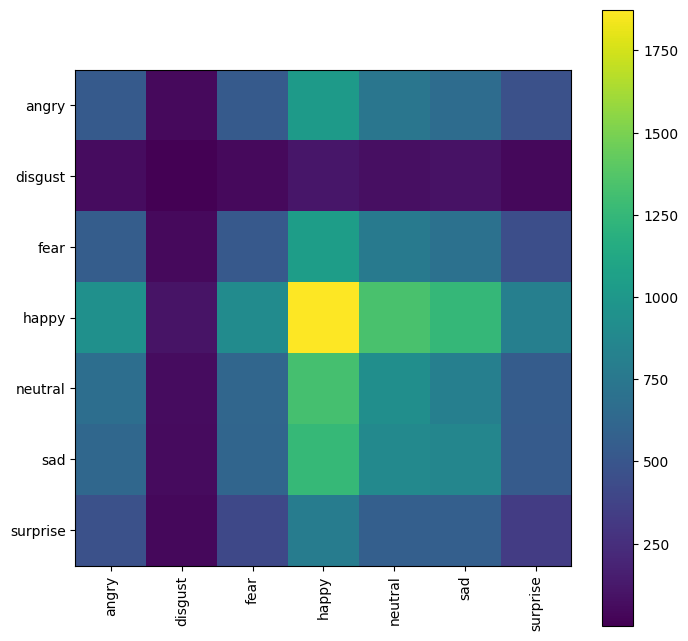

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

####confusion matrix for test set

113/113 [==============================] - 3s 27ms/step
Confusion Matrix
[[127   9 107 240 202 157 116]
 [ 16   1  11  28  21  18  16]
 [148   6 123 266 177 184 120]
 [264  13 235 433 331 289 209]
 [176   8 146 310 258 209 126]
 [177  15 167 311 224 209 144]
 [129   9  82 197 186 129  99]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.13      0.13       958
     disgust       0.02      0.01      0.01       111
        fear       0.14      0.12      0.13      1024
       happy       0.24      0.24      0.24      1774
     neutral       0.18      0.21      0.20      1233
         sad       0.17      0.17      0.17      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



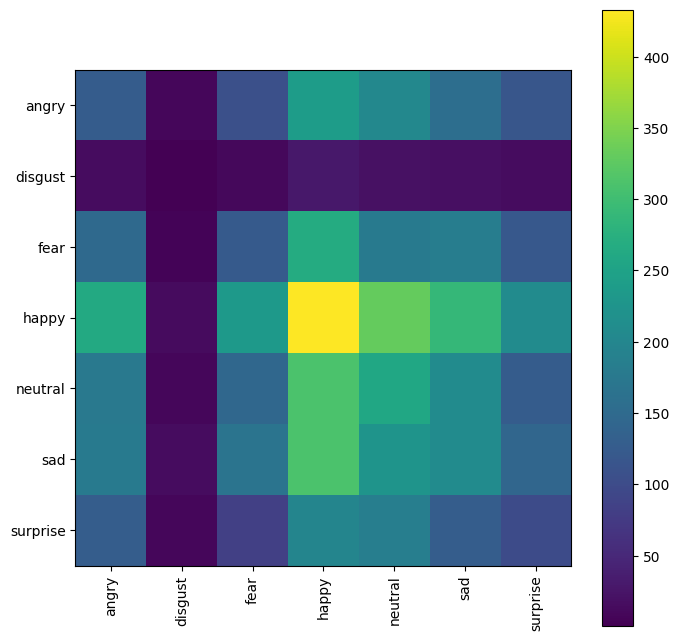

In [ ]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

####loading image

(48, 48)


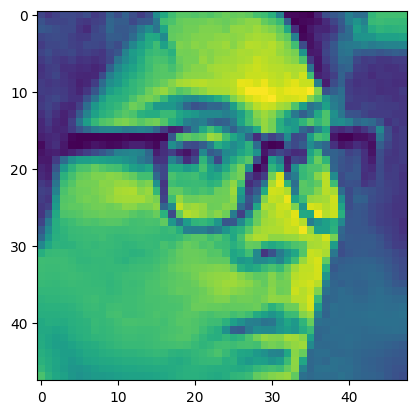

In [ ]:
img = tf.keras.utils.load_img("/content/test/angry/PrivateTest_12000629.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

####prediction

In [ ]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = fernet.predict(img)
result = list(result[0])
print(result)

img_index = result.index(max(result))
print("Predicted Emotion: ", label_dict[img_index])
print("Actual Emotion: Angry")
plt.show()

1/1 [==============================] - 0s 239ms/step
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Predicted Emotion:  Sad
Actual Emotion: Angry


##Load Age and gender detection model and do prediction

Original Gender: Female Original Age: 1
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: 1


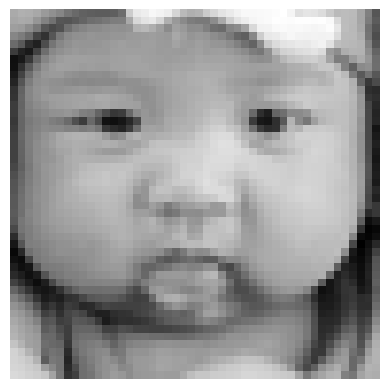

In [ ]:
image_index = 200
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 48, 48, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(48, 48), cmap='gray')

In [ ]:
emotion_model = tf.keras.models.load_model("/content/ferNet.h5")
emotion_model.load_weights("/content/fernet_bestweight.h5")
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

img = np.expand_dims(X[image_index],axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = emotion_model.predict(img)
result = list(result[0])

img_index = result.index(max(result))
print("Predicted Emotion: ", label_dict[img_index])
print("Actual Emotion: Neutral")


1/1 [==============================] - 0s 136ms/step
Predicted Emotion:  Neutral
Actual Emotion: Neutral
